# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

## Import Required Libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


### Exercise 2: Add another convolution layer to `SimpleCNN`

In [18]:
class SimpleCNN_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),  # Added convolution layer
            nn.ReLU(),
            nn.MaxPool2d(2),                   # Added max pooling
        )
        # The input features for the Linear layer will change due to the additional pooling layer.
        # Original: 32 * 16 * 16 = 8192 (after two MaxPool2d operations on 64x64 input, output size is 16x16)
        # New: 64 * 8 * 8 = 4096 (after three MaxPool2d operations on 64x64 input, output size is 8x8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model_v2 = SimpleCNN_V2()
print(model_v2)

SimpleCNN_V2(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## PyTorch Tensors

In [19]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([ 0.0202, -0.3053, -0.9289])
Addition: tensor([1.0202, 1.6947, 2.0711])
Mean: tensor(2.)


## Autograd Basics

In [20]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
print(b)
b.backward()
print(b)
print(a.grad)  # derivative of x^2 is 2x


tensor(13., grad_fn=<SumBackward0>)
tensor(13., grad_fn=<SumBackward0>)
tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [21]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [22]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [24]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [25]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


In [26]:
import torch.nn.functional as F

class RandomMRIDataset(Dataset):
    def __init__(self, length=100, target_size=(128, 128)):
        self.length = length
        self.target_size = target_size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)
        mask = (torch.randn(1, 64, 64) > 0).float()

        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=self.target_size, mode='nearest').squeeze(0)

        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

In [27]:
class SimpleCNN_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model_v2 = SimpleCNN_V2()
print(model_v2)

SimpleCNN_V2(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


### Exercise 3: Implement a small encoder-decoder network (mini U-Net) using `conv_block`

In [28]:
class MiniUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottom = conv_block(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv1 = conv_block(64, 32)
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        b = self.bottom(p2)

        u2 = self.up2(b)
        if u2.shape != d2.shape:
            u2 = F.interpolate(u2, size=d2.shape[2:], mode='bilinear', align_corners=False)
        u2_cat = torch.cat([u2, d2], dim=1)
        uc2 = self.up_conv2(u2_cat)

        u1 = self.up1(uc2)
        if u1.shape != d1.shape:
            u1 = F.interpolate(u1, size=d1.shape[2:], mode='bilinear', align_corners=False)
        u1_cat = torch.cat([u1, d1], dim=1)
        uc1 = self.up_conv1(u1_cat)

        out = self.final_conv(uc1)
        return out


mini_unet = MiniUNet()
print(mini_unet)

sample_input = torch.randn(1, 1, 64, 64)
output = mini_unet(sample_input)
print(f"Mini U-Net output shape: {output.shape}")

MiniUNet(
  (down1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottom): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (up_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
 

In [29]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) if not (pred.min() >= 0 and pred.max() <= 1) else pred

    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

preds = torch.randn(1, 1, 64, 64)
targets = (torch.randn(1, 1, 64, 64) > 0).float()

loss = dice_loss(preds, targets)
print(f"Example Dice Loss: {loss.item():.4f}")

Example Dice Loss: 0.4952


### Exercise 5: Train the CNN on the random dataset and plot the loss curve using matplotlib

Starting CNN training...
Epoch 1/5, Loss: 0.7693
Epoch 2/5, Loss: 0.7114
Epoch 3/5, Loss: 0.6961
Epoch 4/5, Loss: 0.6945
Epoch 5/5, Loss: 0.6911
Training finished.


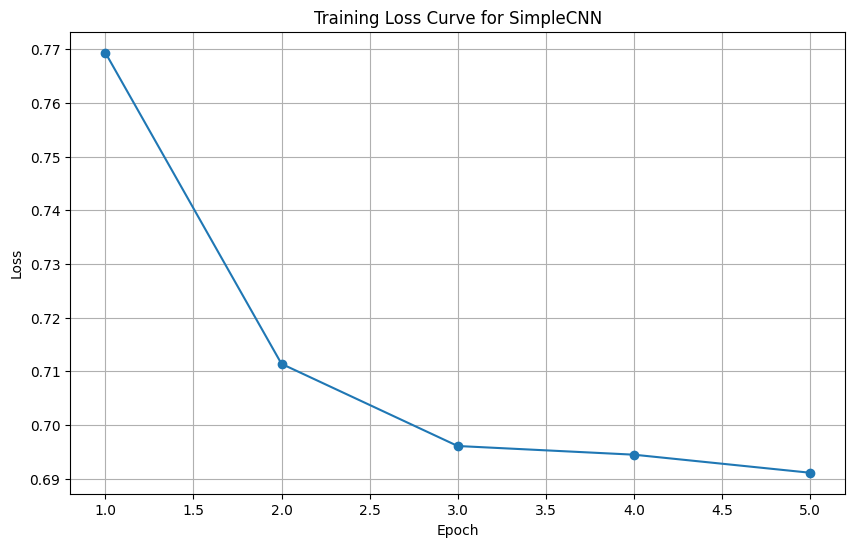

In [30]:
model_for_training = SimpleCNN()

dataset_for_cnn_training = RandomMRIDataset(target_size=(64, 64))
loader_for_cnn_training = DataLoader(dataset_for_cnn_training, batch_size=8, shuffle=True)

criterion_bce = nn.BCEWithLogitsLoss()
optimizer_cnn = optim.Adam(model_for_training.parameters(), lr=1e-3)

num_epochs = 5
loss_history = []

print("Starting CNN training...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, masks in loader_for_cnn_training:
        optimizer_cnn.zero_grad()

        dummy_targets = (images.mean(dim=[-1, -2, -3]) > 0).float().unsqueeze(1)

        preds = model_for_training(images)
        loss = criterion_bce(preds, dummy_targets)

        loss.backward()
        optimizer_cnn.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader_for_cnn_training)
    loss_history.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}')

print("Training finished.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title('Training Loss Curve for SimpleCNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()